## Traditional Machine Learning for E-commerce Text Classification

**Author**: Raissa IRUTINGABO  
**Date**: February 6, 2026  
**Model Architecture**: Logistic Regression

## Table of Contents
1. [Setup & Imports](#setup)
2. [Dataset Loading & Exploration](#exploration)
3. [Exploratory Data Analysis (EDA)](#eda)
4. [Data Preparation](#data-prep)
5. [Word2Vec Skip-gram Implementation](#skipgram)
6. [Word2Vec CBOW Implementation](#cbow)
7. [FastText Implementation](#fasttext)
8. [Logistic Regression Training & Evaluation](#models)
9. [Comparative Analysis](#comparison)
10. [Results & Discussion](#results)

## 1. Setup & Imports

In [40]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time
from collections import Counter
import json
warnings.filterwarnings('ignore')

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Visualization
from wordcloud import WordCloud
from matplotlib.patches import Patch

# Scikit-learn
from sklearn.model_selection import (
    cross_val_score, GridSearchCV, StratifiedKFold,
    learning_curve, validation_curve, cross_validate
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder

# Gensim for Word2Vec and FastText
from gensim.models import Word2Vec, FastText
from gensim.utils import simple_preprocess

# Joblib for model saving
import joblib

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("All libraries imported successfully!")
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
Python version: 3.13.7 | packaged by Anaconda, Inc. | (main, Sep  9 2025, 19:54:37) [MSC v.1929 64 bit (AMD64)]
NumPy version: 2.4.1
Pandas version: 2.3.3


In [41]:
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
print("NLTK resources downloaded successfully!")

NLTK resources downloaded successfully!


## 2. Dataset Loading & Initial Exploration

Loading the preprocessed e-commerce text classification dataset. The dataset contains product descriptions across multiple categories.

In [42]:
# Define paths
BASE_DIR = Path('../../data/preprocessed_data')
TRAIN_PATH = BASE_DIR / 'train.csv'
VAL_PATH = BASE_DIR / 'validation.csv'
TEST_PATH = BASE_DIR / 'test.csv'

# Load datasets
print("Loading preprocessed datasets...")
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"\nDataset Sizes:")
print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"Test set: {len(test_df):,} samples")
print(f"Total: {len(train_df) + len(val_df) + len(test_df):,} samples")

# Display first few rows
print("\nFirst 3 samples from training set:")
train_df.head(3)

Loading preprocessed datasets...

Dataset Sizes:
Training set: 35,317 samples
Validation set: 7,544 samples
Test set: 7,564 samples
Total: 50,425 samples

First 3 samples from training set:


,text,category
0,cambridge checkpoint english workbook book des...,Books
1,iball soundwave channel multimedia speaker bla...,Electronics
2,sailing alone around world,Books


In [43]:
# Basic dataset information
print("Training Data Info:")
print(train_df.info())

print("\nColumn Names:", train_df.columns.tolist())
print("\nCategories:", train_df['category'].unique())
print(f"Number of categories: {train_df['category'].nunique()}")

# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35317 entries, 0 to 35316
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      35317 non-null  object
 1   category  35317 non-null  object
dtypes: object(2)
memory usage: 552.0+ KB
None

Column Names: ['text', 'category']

Categories: ['Books' 'Electronics' 'Household' 'Clothing & Accessories']
Number of categories: 4

Missing Values:
text        0
category    0
dtype: int64


## 3. Exploratory Data Analysis (EDA)

Comprehensive analysis of dataset characteristics to understand distribution patterns, text properties, and potential challenges.

### 3.1 Class Distribution Analysis

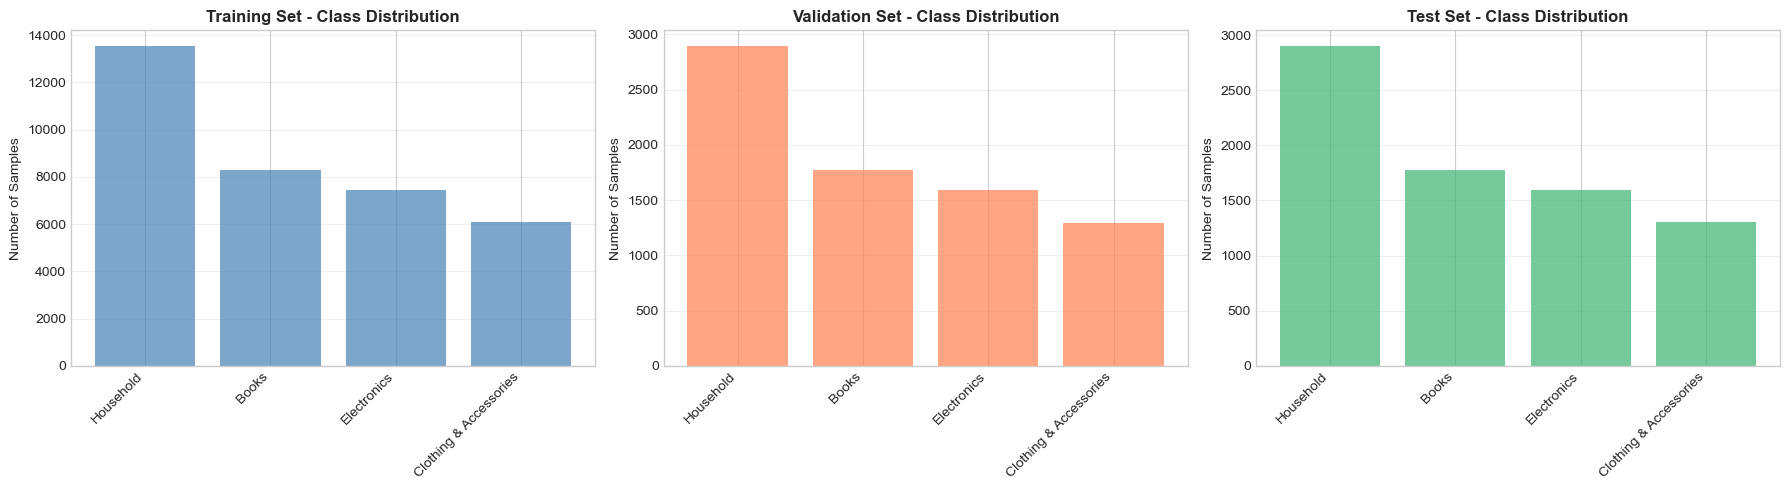

Training Set Class Distribution:
category
Household                 13526
Books                      8279
Electronics                7439
Clothing & Accessories     6073
Name: count, dtype: int64

Class Balance Ratio (min/max): 0.449


In [44]:
# Create results directory
os.makedirs('../../results/logistic_regression', exist_ok=True)

# Category distribution across all datasets
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Training set distribution
train_counts = train_df['category'].value_counts()
axes[0].bar(range(len(train_counts)), train_counts.values, color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(train_counts)))
axes[0].set_xticklabels(train_counts.index, rotation=45, ha='right')
axes[0].set_title('Training Set - Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Samples')
axes[0].grid(axis='y', alpha=0.3)

# Validation set distribution
val_counts = val_df['category'].value_counts()
axes[1].bar(range(len(val_counts)), val_counts.values, color='coral', alpha=0.7)
axes[1].set_xticks(range(len(val_counts)))
axes[1].set_xticklabels(val_counts.index, rotation=45, ha='right')
axes[1].set_title('Validation Set - Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Samples')
axes[1].grid(axis='y', alpha=0.3)

# Test set distribution
test_counts = test_df['category'].value_counts()
axes[2].bar(range(len(test_counts)), test_counts.values, color='mediumseagreen', alpha=0.7)
axes[2].set_xticks(range(len(test_counts)))
axes[2].set_xticklabels(test_counts.index, rotation=45, ha='right')
axes[2].set_title('Test Set - Class Distribution', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Number of Samples')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/logistic_regression/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("Training Set Class Distribution:")
print(train_counts)
print(f"\nClass Balance Ratio (min/max): {train_counts.min() / train_counts.max():.3f}")

### 3.3 Text Length Analysis

### 3.2 Word Clouds per Category

Visualize the most frequent words in each product category to understand distinctive terminology.

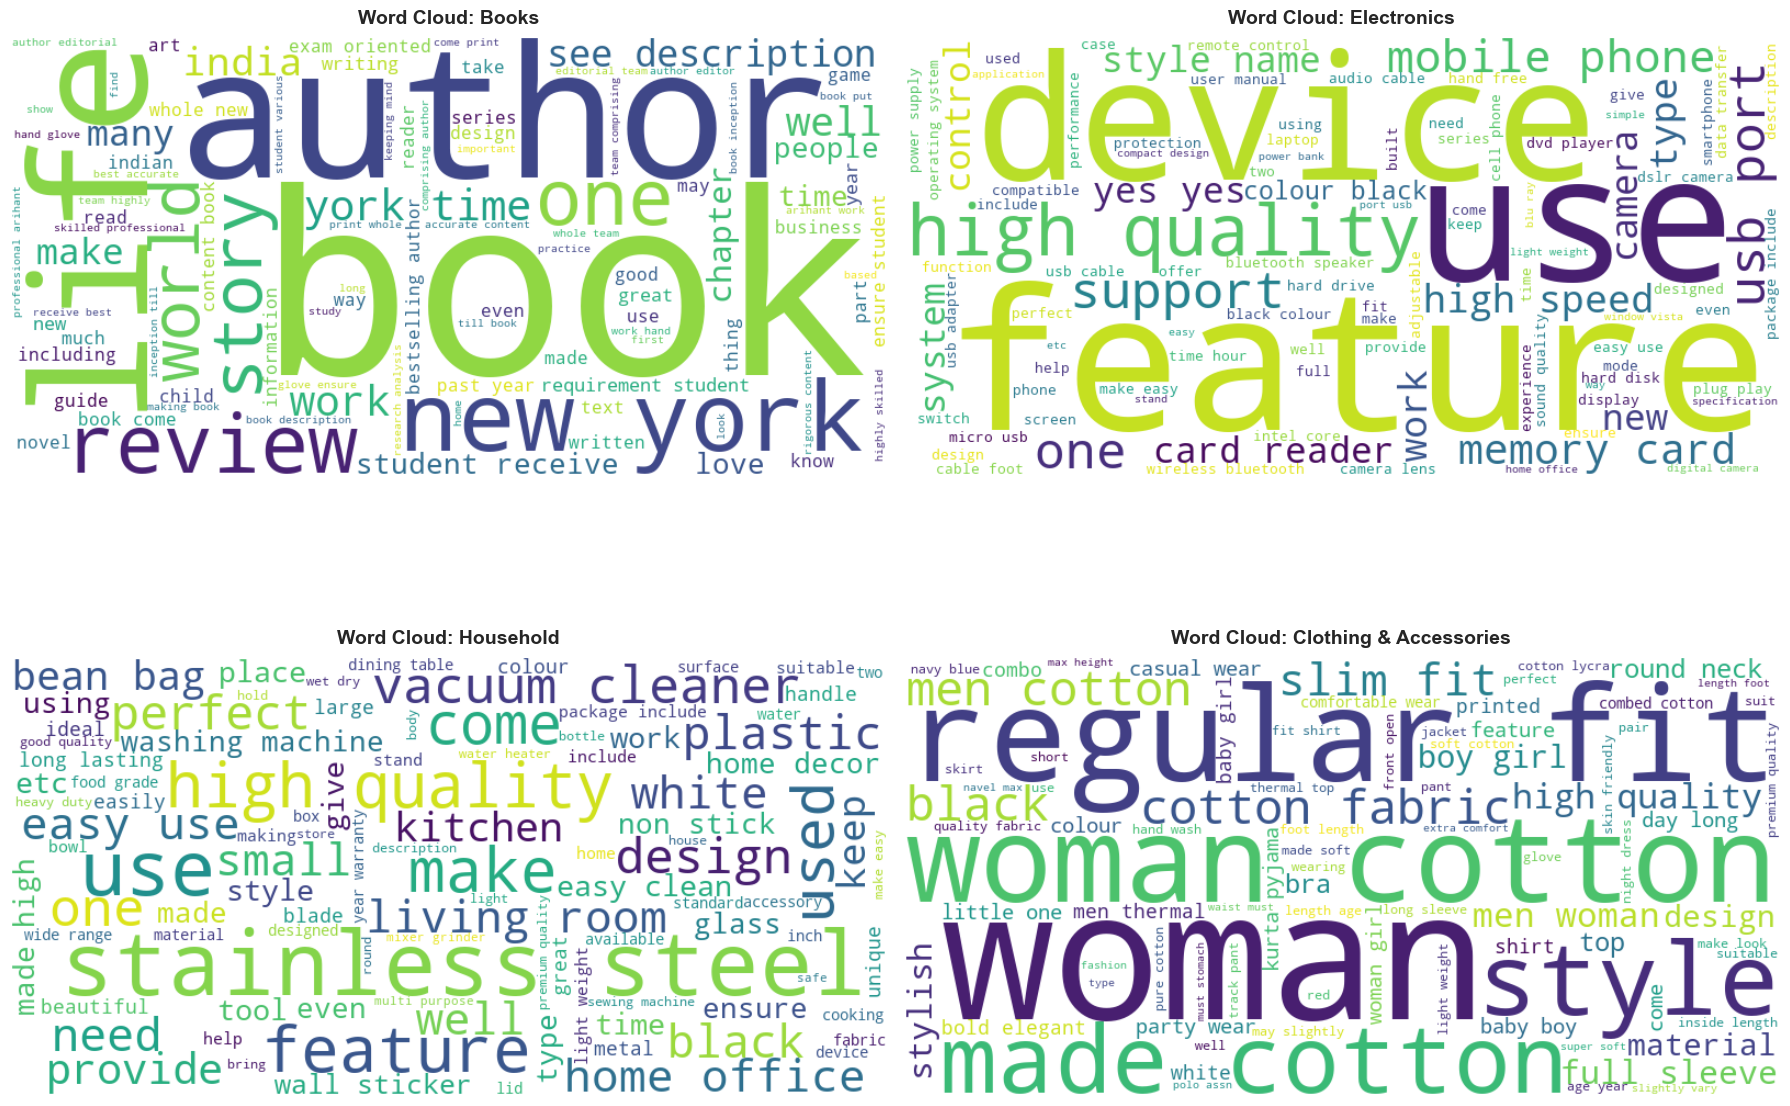

Word clouds generated for all categories!


In [45]:
# Create word clouds for each category
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
categories = train_df['category'].unique()

for idx, category in enumerate(categories):
    ax = axes[idx // 2, idx % 2]
    
    # Get all text for this category
    category_text = ' '.join(train_df[train_df['category'] == category]['text'].astype(str))
    
    # Generate word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(category_text)
    
    # Display word cloud
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f'Word Cloud: {category}', fontsize=14, fontweight='bold', pad=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('../../results/logistic_regression/word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

print("Word clouds generated for all categories!")

In [46]:
# Calculate text statistics
def calculate_text_stats(df):
    """Calculate various text length statistics"""
    df = df.copy()
    df['text_length'] = df['text'].astype(str).apply(len)
    df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['text'].astype(str).apply(
        lambda x: np.mean([len(word) for word in x.split()]) if len(x.split()) > 0 else 0
    )
    return df

# Add statistics to dataframes
train_stats = calculate_text_stats(train_df)
val_stats = calculate_text_stats(val_df)
test_stats = calculate_text_stats(test_df)

print("Text Length Statistics (Training Set):")
print("\nCharacter Count:")
print(train_stats['text_length'].describe())
print("\nWord Count:")
print(train_stats['word_count'].describe())
print("\nAverage Word Length:")
print(train_stats['avg_word_length'].describe())

Text Length Statistics (Training Set):

Character Count:
count    35317.000000
mean       500.180678
std        668.303491
min          3.000000
25%        156.000000
50%        344.000000
75%        662.000000
max      33477.000000
Name: text_length, dtype: float64

Word Count:
count    35317.000000
mean        70.265934
std         91.394752
min          1.000000
25%         23.000000
50%         49.000000
75%         93.000000
max       4536.000000
Name: word_count, dtype: float64

Average Word Length:
count    35317.000000
mean         6.080475
std          0.730716
min          3.000000
25%          5.673469
50%          6.022222
75%          6.410714
max         14.000000
Name: avg_word_length, dtype: float64


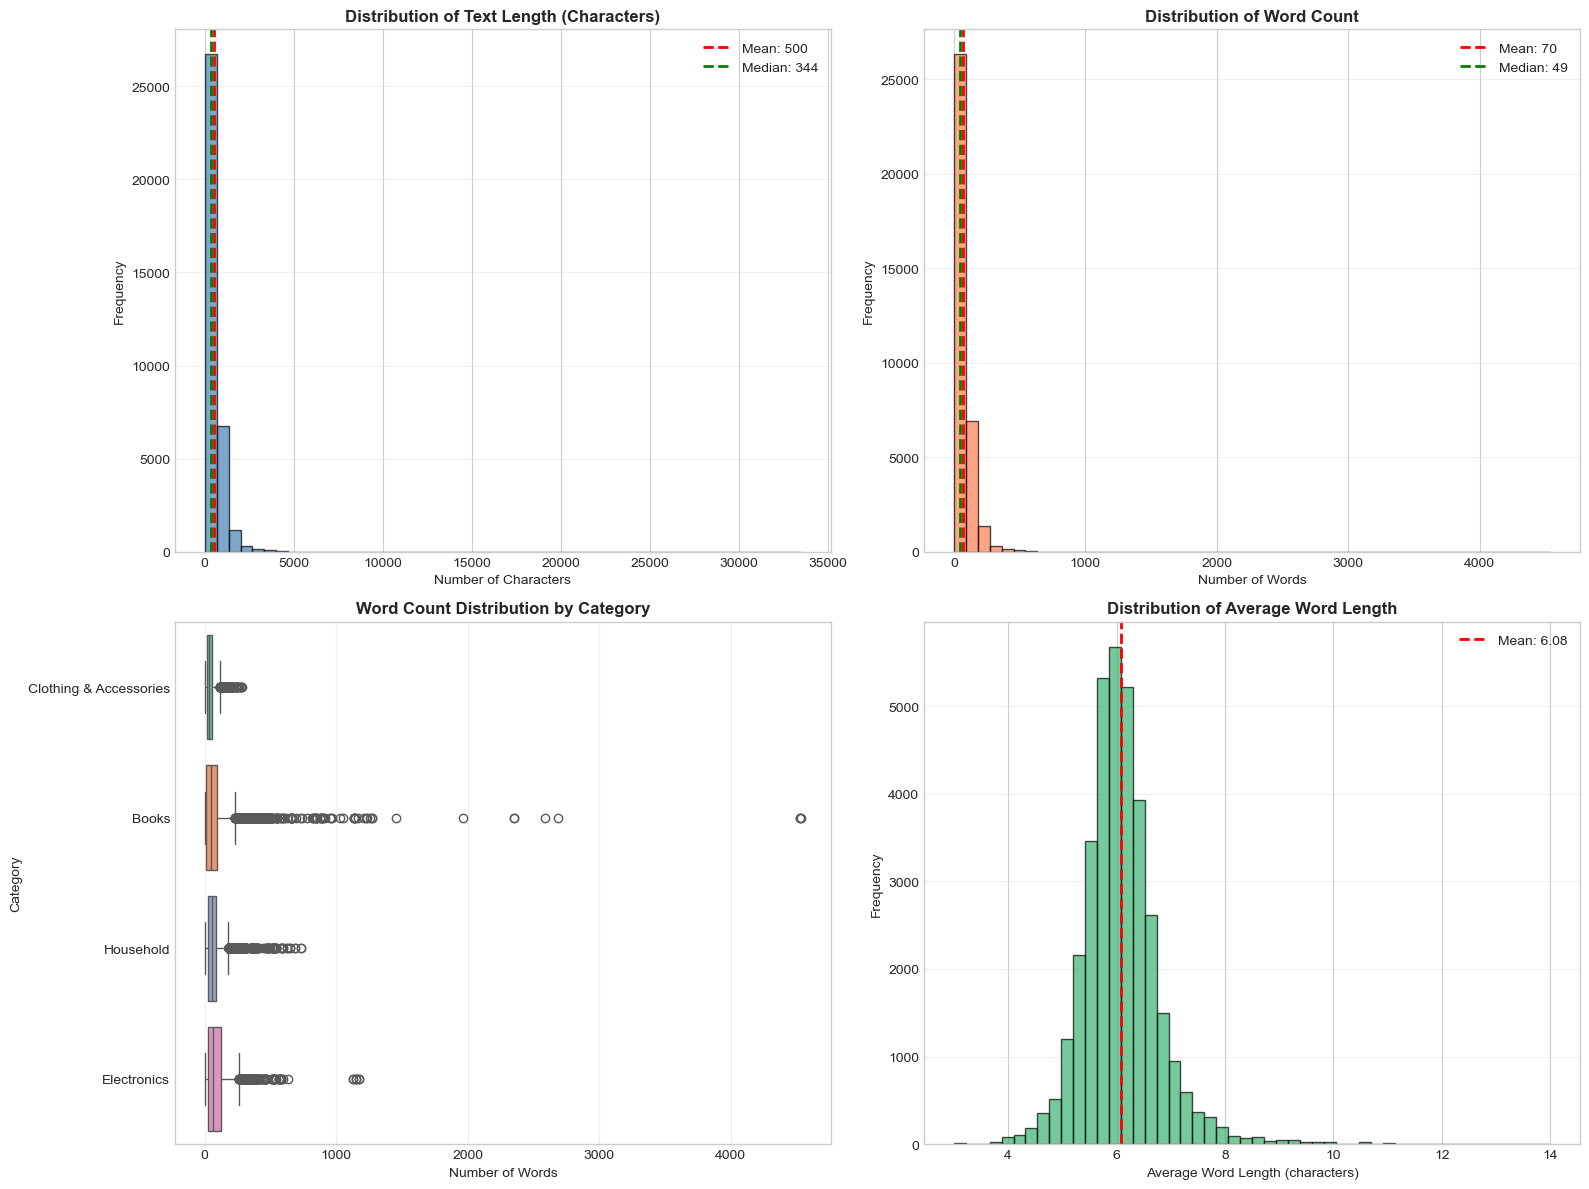

In [47]:
# Visualization of text length distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character count distribution
axes[0, 0].hist(train_stats['text_length'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(train_stats['text_length'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {train_stats['text_length'].mean():.0f}")
axes[0, 0].axvline(train_stats['text_length'].median(), color='green', linestyle='--', linewidth=2, 
                    label=f"Median: {train_stats['text_length'].median():.0f}")
axes[0, 0].set_xlabel('Number of Characters')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Text Length (Characters)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Word count distribution
axes[0, 1].hist(train_stats['word_count'], bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(train_stats['word_count'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {train_stats['word_count'].mean():.0f}")
axes[0, 1].axvline(train_stats['word_count'].median(), color='green', linestyle='--', linewidth=2, 
                    label=f"Median: {train_stats['word_count'].median():.0f}")
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Word Count', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Word count by category (boxplot)
category_order = train_stats.groupby('category')['word_count'].median().sort_values().index
sns.boxplot(data=train_stats, y='category', x='word_count', order=category_order, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Category')
axes[1, 0].set_title('Word Count Distribution by Category', fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

# Average word length distribution
axes[1, 1].hist(train_stats['avg_word_length'], bins=50, color='mediumseagreen', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(train_stats['avg_word_length'].mean(), color='red', linestyle='--', linewidth=2, 
                    label=f"Mean: {train_stats['avg_word_length'].mean():.2f}")
axes[1, 1].set_xlabel('Average Word Length (characters)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Average Word Length', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/logistic_regression/text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.3 Vocabulary Analysis

In [48]:
# Vocabulary analysis
def get_vocabulary_stats(df):
    """Extract vocabulary statistics from text data"""
    all_words = []
    for text in df['text'].astype(str):
        words = text.lower().split()
        all_words.extend(words)
    
    word_freq = Counter(all_words)
    return word_freq, len(word_freq), len(all_words)

train_vocab, train_vocab_size, train_total_words = get_vocabulary_stats(train_df)
val_vocab, val_vocab_size, val_total_words = get_vocabulary_stats(val_df)
test_vocab, test_vocab_size, test_total_words = get_vocabulary_stats(test_df)

print("Vocabulary Statistics:")
print(f"\nTraining Set:")
print(f"  Unique words: {train_vocab_size:,}")
print(f"  Total words: {train_total_words:,}")
print(f"  Type-Token Ratio: {train_vocab_size / train_total_words:.4f}")

print(f"\nValidation Set:")
print(f"  Unique words: {val_vocab_size:,}")
print(f"  Total words: {val_total_words:,}")

print(f"\nTest Set:")
print(f"  Unique words: {test_vocab_size:,}")
print(f"  Total words: {test_total_words:,}")

print(f"\nTop 20 Most Common Words:")
for word, count in train_vocab.most_common(20):
    print(f"  {word}: {count:,}")

Vocabulary Statistics:

Training Set:
  Unique words: 52,012
  Total words: 2,481,582
  Type-Token Ratio: 0.0210

Validation Set:
  Unique words: 29,095
  Total words: 530,166

Test Set:
  Unique words: 28,554
  Total words: 525,615

Top 20 Most Common Words:
  book: 12,606
  one: 9,112
  time: 9,075
  use: 8,650
  make: 8,553
  quality: 8,477
  easy: 8,445
  design: 8,222
  high: 7,887
  black: 7,838
  also: 7,717
  home: 7,678
  author: 7,574
  made: 7,537
  feature: 6,648
  power: 6,418
  come: 6,365
  new: 6,317
  light: 5,912
  life: 5,691


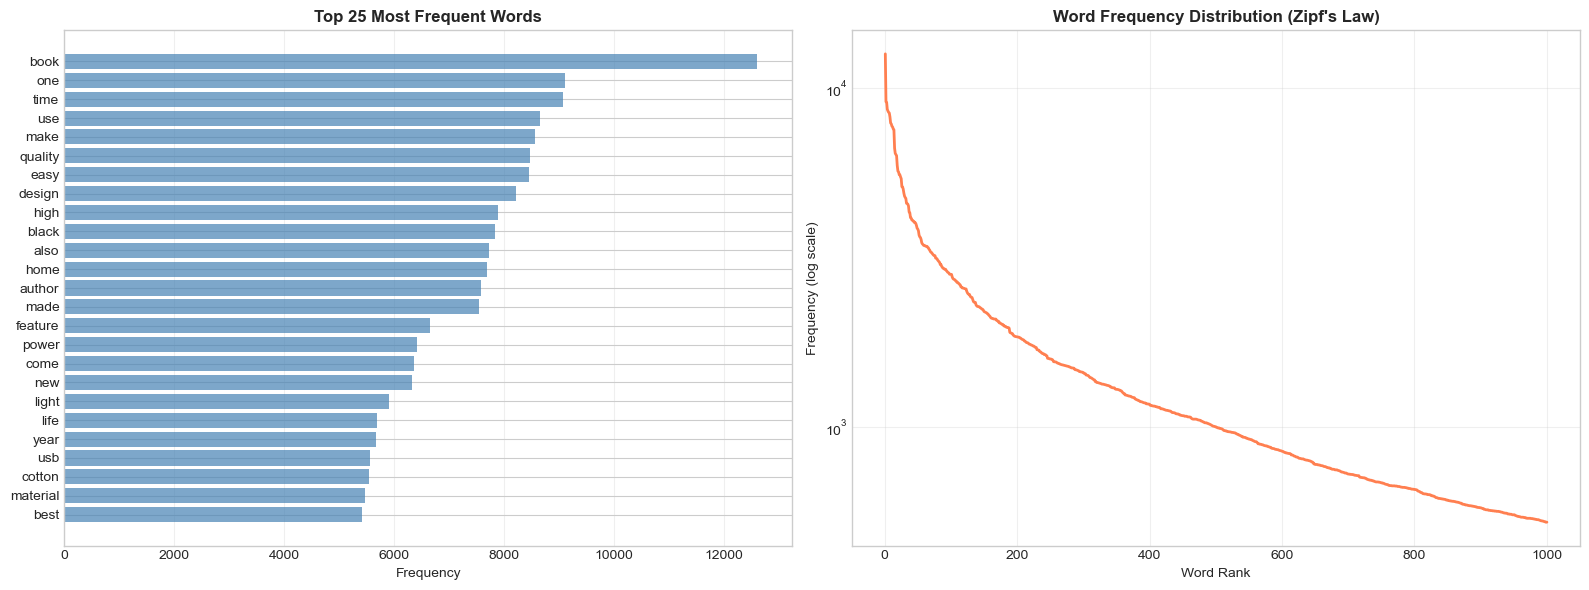

In [49]:
# Visualize word frequency distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 25 most common words
top_words = train_vocab.most_common(25)
words, counts = zip(*top_words)
axes[0].barh(range(len(words)), counts, color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(words)))
axes[0].set_yticklabels(words)
axes[0].invert_yaxis()
axes[0].set_xlabel('Frequency')
axes[0].set_title('Top 25 Most Frequent Words', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Word frequency distribution (log scale)
freq_values = sorted(train_vocab.values(), reverse=True)
axes[1].plot(range(1, min(1001, len(freq_values)+1)), freq_values[:1000], color='coral', linewidth=2)
axes[1].set_xlabel('Word Rank')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_yscale('log')
axes[1].set_title("Word Frequency Distribution (Zipf's Law)", fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/logistic_regression/vocabulary_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### 3.4 Category-Specific Vocabulary

In [50]:
# Extract category-specific vocabularies
category_vocabs = {}
for category in train_df['category'].unique():
    category_texts = train_df[train_df['category'] == category]['text'].astype(str)
    words = []
    for text in category_texts:
        words.extend(text.lower().split())
    category_vocabs[category] = Counter(words)

# Print top words per category
print("Top 10 Words by Category:\n")
for category, vocab in category_vocabs.items():
    print(f"{category}:")
    top_10 = vocab.most_common(10)
    print(", ".join([f"{word}({count})" for word, count in top_10]))
    print()

Top 10 Words by Category:

Books:
book(11673), author(7308), time(3868), one(3638), new(3430), life(3410), year(2836), review(2818), world(2761), student(2299)

Electronics:
usb(5201), device(4204), camera(3817), black(3590), cable(3397), bluetooth(3319), speaker(3243), high(3130), audio(3117), power(3078)

Household:
home(5820), use(5315), easy(5190), steel(4261), quality(4178), design(4147), made(4108), make(3885), water(3855), light(3593)

Clothing & Accessories:
woman(4055), cotton(3886), men(3033), wear(2858), fit(2493), fabric(2300), look(2158), made(2111), girl(1864), shirt(1686)



## 4. Data Preparation for Embedding Models

Prepare the text data and labels for all embedding implementations.

In [51]:
# Prepare data for modeling
X_train_text = train_df['text'].astype(str).values
X_val_text = val_df['text'].astype(str).values
X_test_text = test_df['text'].astype(str).values

y_train = train_df['category'].values
y_val = val_df['category'].values
y_test = test_df['category'].values

print(f"Training samples: {len(X_train_text)}")
print(f"Validation samples: {len(X_val_text)}")
print(f"Test samples: {len(X_test_text)}")
print(f"\nUnique categories: {len(np.unique(y_train))}")

Training samples: 35317
Validation samples: 7544
Test samples: 7564

Unique categories: 4


## 5. Word2Vec Skip-gram Implementation

### Word2Vec Skip-gram Theory

Word2Vec Skip-gram (Mikolov et al., 2013) is a neural network-based model that learns word embeddings by predicting context words from a target word. The Skip-gram architecture is particularly effective at capturing semantic relationships and works well with smaller datasets.

**Key characteristics:**
- Predicts context words given a center word
- Better with rare words compared to CBOW
- Generates dense vector representations (typically 100-300 dimensions)
- Captures semantic and syntactic relationships

**References:** Mikolov et al. (2013) - "Efficient Estimation of Word Representations in Vector Space"

In [52]:
# Set embedding parameters
EMBEDDING_DIM = 100

# Tokenize texts for Word2Vec training
print("Tokenizing texts for Word2Vec training...")
tokenized_train = [simple_preprocess(doc) for doc in X_train_text]

print(f"Prepared {len(tokenized_train):,} documents for training")
print(f"Sample tokenized text: {tokenized_train[0][:15]}...")

Tokenizing texts for Word2Vec training...


Prepared 35,317 documents for training
Sample tokenized text: ['cambridge', 'checkpoint', 'english', 'workbook', 'book', 'description', 'ensure', 'thorough', 'understanding', 'course', 'structure', 'follows', 'accompanying', 'textbook', 'exercise']...


In [53]:
# Train Word2Vec Skip-gram model
print("\nTraining Word2Vec Skip-gram model...")
start_time = time.time()

w2v_skipgram = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,  # Context window size
    min_count=2,  # Ignore words with frequency less than 2
    workers=4,  # Number of CPU cores for training
    sg=1,  # Skip-gram (1) vs CBOW (0)
    epochs=20,  # Number of training iterations
    seed=RANDOM_STATE
)

skipgram_train_time = time.time() - start_time

print(f"\n✓ Word2Vec Skip-gram training completed in {skipgram_train_time:.2f} seconds")
print(f"Vocabulary size: {len(w2v_skipgram.wv):,}")
print(f"Vector dimension: {w2v_skipgram.vector_size}")

# Save the model
w2v_skipgram.save('../../models/logistic_regression/word2vec_skipgram.model')
print("Model saved.")


Training Word2Vec Skip-gram model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl


✓ Word2Vec Skip-gram training completed in 194.65 seconds
Vocabulary size: 37,685
Vector dimension: 100
Model saved.


### Skip-gram Feature Extraction

Create document-level embeddings by averaging Word2Vec vectors of all words in each document.

In [54]:
# Function to load GloVe embeddings
def load_glove_embeddings(glove_path, embedding_dim=100):
    """
    Load pre-trained GloVe embeddings.
    Download from: https://nlp.stanford.edu/projects/glove/
    """
    print(f"Loading GloVe embeddings from {glove_path}...")
    embeddings_index = {}
    
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                coeffs = np.asarray(values[1:], dtype='float32')
                embeddings_index[word] = coeffs
        
        print(f"Loaded {len(embeddings_index):,} word vectors.")
        return embeddings_index
    
    except FileNotFoundError:
        print(f"\nGloVe file not found at {glove_path}")
        print("Please download GloVe embeddings from: https://nlp.stanford.edu/projects/glove/")
        print("Recommended: glove.6B.100d.txt")
        return None

# Set GloVe path (update this path based on where you downloaded GloVe)
GLOVE_PATH = '../../embeddings/glove.6B.100d.txt'
EMBEDDING_DIM = 100

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(GLOVE_PATH, EMBEDDING_DIM)

Loading GloVe embeddings from ../../embeddings/glove.6B.100d.txt...

GloVe file not found at ../../embeddings/glove.6B.100d.txt
Please download GloVe embeddings from: https://nlp.stanford.edu/projects/glove/
Recommended: glove.6B.100d.txt


### Skip-gram Feature Extraction

Create document-level embeddings by averaging Word2Vec vectors of all words in each document.

In [55]:
def text_to_word2vec_vector(text, model, embedding_dim=100):
    """Convert text to Word2Vec embedding vector by averaging word vectors"""
    words = simple_preprocess(text)
    word_vectors = []
    
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    
    if len(word_vectors) == 0:
        return np.zeros(embedding_dim)
    
    return np.mean(word_vectors, axis=0)

def create_word2vec_features(texts, model, embedding_dim=100):
    """Create Word2Vec feature matrix for all texts"""
    features = np.zeros((len(texts), embedding_dim))
    
    for i, text in enumerate(texts):
        features[i] = text_to_word2vec_vector(text, model, embedding_dim)
    
    return features

print("Creating Skip-gram feature matrices...")
start_time = time.time()

X_train_skipgram = create_word2vec_features(X_train_text, w2v_skipgram, EMBEDDING_DIM)
X_val_skipgram = create_word2vec_features(X_val_text, w2v_skipgram, EMBEDDING_DIM)
X_test_skipgram = create_word2vec_features(X_test_text, w2v_skipgram, EMBEDDING_DIM)

skipgram_feat_time = time.time() - start_time

print(f"\nSkip-gram feature creation completed in {skipgram_feat_time:.2f} seconds")
print(f"\nFeature matrix shapes:")
print(f"  Training: {X_train_skipgram.shape}")
print(f"  Validation: {X_val_skipgram.shape}")
print(f"  Test: {X_test_skipgram.shape}")

# Calculate vocabulary coverage
total_words = 0
covered_words = 0
for text in X_train_text:
    words = simple_preprocess(text)
    total_words += len(words)
    covered_words += sum(1 for word in words if word in w2v_skipgram.wv)

print(f"\nVocabulary coverage: {covered_words / total_words * 100:.2f}%")
print(f"Covered words: {covered_words:,} / {total_words:,}")

Creating Skip-gram feature matrices...

Skip-gram feature creation completed in 19.77 seconds

Feature matrix shapes:
  Training: (35317, 100)
  Validation: (7544, 100)
  Test: (7564, 100)

Vocabulary coverage: 99.46%
Covered words: 2,465,873 / 2,479,306


## 6. Word2Vec CBOW Implementation

### Word2Vec CBOW Theory

Continuous Bag of Words (CBOW) is the complement to Skip-gram in the Word2Vec framework. Instead of predicting context words from a target word, CBOW predicts a target word from its context words (Mikolov et al., 2013).

**Key characteristics:**
- Predicts center word given context words
- Faster to train than Skip-gram
- Better with frequent words
- More stable with larger contexts

**Comparison with Skip-gram:**
- Skip-gram: better for rare words, higher quality for small corpora
- CBOW: faster training, better for frequent words, more efficient

**References:** Mikolov et al. (2013) - "Efficient Estimation of Word Representations in Vector Space"

In [56]:
# Train Word2Vec CBOW model
print("\nTraining Word2Vec CBOW model...")
start_time = time.time()

w2v_cbow = Word2Vec(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,  # Context window size
    min_count=2,  # Ignore words with frequency less than 2
    workers=4,  # Number of CPU cores for training
    sg=0,  # CBOW (0) vs Skip-gram (1)
    epochs=20,  # Number of training iterations
    seed=RANDOM_STATE
)

cbow_train_time = time.time() - start_time

print(f"\n✓ Word2Vec CBOW training completed in {cbow_train_time:.2f} seconds")
print(f"Vocabulary size: {len(w2v_cbow.wv):,}")
print(f"Vector dimension: {w2v_cbow.vector_size}")

# Save the model
w2v_cbow.save('../../models/logistic_regression/word2vec_cbow.model')
print("Model saved.")


Training Word2Vec CBOW model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'



✓ Word2Vec CBOW training completed in 65.05 seconds
Vocabulary size: 37,685
Vector dimension: 100
Model saved.


### CBOW Feature Extraction

Create document-level embeddings using the CBOW model.

In [57]:
print("Creating CBOW feature matrices...")
start_time = time.time()

X_train_cbow = create_word2vec_features(X_train_text, w2v_cbow, EMBEDDING_DIM)
X_val_cbow = create_word2vec_features(X_val_text, w2v_cbow, EMBEDDING_DIM)
X_test_cbow = create_word2vec_features(X_test_text, w2v_cbow, EMBEDDING_DIM)

cbow_feat_time = time.time() - start_time

print(f"\nCBOW feature creation completed in {cbow_feat_time:.2f} seconds")
print(f"\nFeature matrix shapes:")
print(f"  Training: {X_train_cbow.shape}")
print(f"  Validation: {X_val_cbow.shape}")
print(f"  Test: {X_test_cbow.shape}")

# Calculate vocabulary coverage
covered_words_cbow = sum(1 for text in X_train_text for word in simple_preprocess(text) if word in w2v_cbow.wv)
print(f"\nVocabulary coverage: {covered_words_cbow / total_words * 100:.2f}%")

Creating CBOW feature matrices...

CBOW feature creation completed in 21.27 seconds

Feature matrix shapes:
  Training: (35317, 100)
  Validation: (7544, 100)
  Test: (7564, 100)

Vocabulary coverage: 99.46%


## 7. FastText Implementation

### FastText Theory

FastText extends Word2Vec by learning representations for character n-grams in addition to words (Bojanowski et al., 2017). This allows it to:
- Handle out-of-vocabulary (OOV) words by composing vectors from character n-grams
- Capture morphological information (prefixes, suffixes, roots)
- Work better with rare words and misspellings
- Generate embeddings for words not seen during training

**Key advantages for e-commerce:**
- Product names with variations and typos
- Brand names and technical specifications
- Multilingual product descriptions

**References:** Bojanowski et al. (2017) - "Enriching Word Vectors with Subword Information"

In [58]:
# Train FastText model on our corpus
print("\nTraining FastText model...")
start_time = time.time()

fasttext_model = FastText(
    sentences=tokenized_train,
    vector_size=EMBEDDING_DIM,
    window=5,  # Context window size
    min_count=2,  # Ignore words with frequency less than 2
    workers=4,  # Number of CPU cores for training
    sg=0,  # Use CBOW (0) - faster for large corpora
    min_n=3,  # Min length of char n-grams
    max_n=6,  # Max length of char n-grams
    epochs=20,  # Number of training iterations
    seed=RANDOM_STATE
)

fasttext_train_time = time.time() - start_time

print(f"\n✓ FastText training completed in {fasttext_train_time:.2f} seconds")
print(f"Vocabulary size: {len(fasttext_model.wv):,}")
print(f"Vector dimension: {fasttext_model.vector_size}")

# Save the model
fasttext_model.save('../../models/logistic_regression/fasttext_model.bin')
print("FastText model saved.")


Training FastText model...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'



✓ FastText training completed in 393.61 seconds
Vocabulary size: 37,685
Vector dimension: 100
FastText model saved.


### FastText Feature Extraction

In [59]:
print("Creating FastText feature matrices...")
start_time = time.time()

X_train_fasttext = create_word2vec_features(X_train_text, fasttext_model, EMBEDDING_DIM)
X_val_fasttext = create_word2vec_features(X_val_text, fasttext_model, EMBEDDING_DIM)
X_test_fasttext = create_word2vec_features(X_test_text, fasttext_model, EMBEDDING_DIM)

fasttext_feat_time = time.time() - start_time

print(f"\nFastText feature creation completed in {fasttext_feat_time:.2f} seconds")
print(f"\nFeature matrix shapes:")
print(f"  Training: {X_train_fasttext.shape}")
print(f"  Validation: {X_val_fasttext.shape}")
print(f"  Test: {X_test_fasttext.shape}")

# Calculate vocabulary coverage for FastText
covered_words_fasttext = sum(1 for text in X_train_text for word in simple_preprocess(text) if word in fasttext_model.wv)
print(f"\nVocabulary coverage: {covered_words_fasttext / total_words * 100:.2f}%")

Creating FastText feature matrices...

FastText feature creation completed in 24.08 seconds

Feature matrix shapes:
  Training: (35317, 100)
  Validation: (7544, 100)
  Test: (7564, 100)

Vocabulary coverage: 100.00%


## 8. Logistic Regression Training & Evaluation

We will train Logistic Regression models with all three embedding techniques:
1. **Word2Vec Skip-gram**: Predicts context from target word
2. **Word2Vec CBOW**: Predicts target from context words
3. **FastText**: Character n-gram based embeddings with OOV handling

Each model will be hyperparameter tuned using GridSearchCV with cross-validation.

In [60]:
# Initialize results storage
results = {
    'embedding': [],
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Store trained models
trained_models = {}

### Helper Functions

In [61]:
def train_with_gridsearch(base_model, param_grid, X_train, y_train, X_val, y_val, 
                         X_test, y_test, embedding_name, model_name, cv=3):
    """Train model with hyperparameter tuning using GridSearchCV"""
    print(f"\n{'='*60}")
    print(f"Training {model_name} with {embedding_name}")
    print(f"Performing GridSearchCV with {cv}-fold cross-validation...")
    print(f"{'='*60}")
    
    # Setup GridSearchCV
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE),
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    # Training with hyperparameter search
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Inference on test set
    start_time = time.time()
    y_pred = best_model.predict(X_test)
    inference_time = time.time() - start_time
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    print(f"\nTest Set Performance:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Training time: {training_time:.2f}s")
    print(f"  Inference time: {inference_time:.4f}s")
    
    # Store model and predictions
    model_key = f"{model_name}_{embedding_name}"
    trained_models[model_key] = {
        'model': best_model,
        'predictions': y_pred,
        'embedding': embedding_name,
        'model_name': model_name,
        'best_params': grid_search.best_params_
    }
    
    # Save model
    model_filename = f'../../models/logistic_regression/{model_name.lower().replace(" ", "_")}_{embedding_name.lower()}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"Model saved to {model_filename}")
    
    return {
        'embedding': embedding_name,
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

### Logistic Regression with All Embeddings

In [62]:
# Logistic Regression hyperparameter grid
# Based on literature: Genkin et al. (2007), Fan et al. (2008)
lr_param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'liblinear'],  # Optimization algorithms
    'max_iter': [500]  # Increased for convergence
}

# Initialize results dictionary
results = {
    'embedding': [],
    'model': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

trained_models = {}

# Train with Word2Vec Skip-gram
print("\n" + "="*60)
print("Training with Word2Vec Skip-gram Embeddings")
print("="*60)
lr_base = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
lr_skipgram_results = train_with_gridsearch(
    lr_base, lr_param_grid,
    X_train_skipgram, y_train, X_val_skipgram, y_val, X_test_skipgram, y_test,
    'Word2Vec Skip-gram', 'Logistic Regression', cv=3
)
for key in results.keys():
    results[key].append(lr_skipgram_results[key])


Training with Word2Vec Skip-gram Embeddings

Training Logistic Regression with Word2Vec Skip-gram
Performing GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'C': 100.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.9435

Test Set Performance:
  Accuracy: 0.9435
  Precision: 0.9436
  Recall: 0.9435
  F1-Score: 0.9435
  Training time: 48.22s
  Inference time: 0.0031s
Model saved to ../../models/logistic_regression/logistic_regression_word2vec skip-gram.pkl


In [63]:
# Train with Word2Vec CBOW
print("\n" + "="*60)
print("Training with Word2Vec CBOW Embeddings")
print("="*60)
lr_cbow_results = train_with_gridsearch(
    lr_base, lr_param_grid,
    X_train_cbow, y_train, X_val_cbow, y_val, X_test_cbow, y_test,
    'Word2Vec CBOW', 'Logistic Regression', cv=3
)
for key in results.keys():
    results[key].append(lr_cbow_results[key])


Training with Word2Vec CBOW Embeddings

Training Logistic Regression with Word2Vec CBOW
Performing GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'C': 100.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.9392

Test Set Performance:
  Accuracy: 0.9384
  Precision: 0.9384
  Recall: 0.9384
  F1-Score: 0.9383
  Training time: 50.56s
  Inference time: 0.0079s
Model saved to ../../models/logistic_regression/logistic_regression_word2vec cbow.pkl


In [64]:
# Train with FastText
print("\n" + "="*60)
print("Training with FastText Embeddings")
print("="*60)
lr_fasttext_results = train_with_gridsearch(
    lr_base, lr_param_grid,
    X_train_fasttext, y_train, X_val_fasttext, y_val, X_test_fasttext, y_test,
    'FastText', 'Logistic Regression', cv=3
)
for key in results.keys():
    results[key].append(lr_fasttext_results[key])


Training with FastText Embeddings

Training Logistic Regression with FastText
Performing GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'C': 10.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.9344

Test Set Performance:
  Accuracy: 0.9348
  Precision: 0.9349
  Recall: 0.9348
  F1-Score: 0.9348
  Training time: 65.42s
  Inference time: 0.0029s
Model saved to ../../models/logistic_regression/logistic_regression_fasttext.pkl


## 9. Comparative Analysis

### Results Summary Tables

In [65]:
# Create results dataframe
results_df = pd.DataFrame(results)

# Display complete results table
print("\n" + "="*80)
print("COMPLETE EXPERIMENTAL RESULTS")
print("="*80 + "\n")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('../../results/logistic_regression/model_comparison.csv', index=False)
print("\nResults saved to: results/logistic_regression/model_comparison.csv")


COMPLETE EXPERIMENTAL RESULTS

         embedding               model  accuracy  precision   recall  f1_score
Word2Vec Skip-gram Logistic Regression  0.943548   0.943567 0.943548  0.943525
     Word2Vec CBOW Logistic Regression  0.938392   0.938419 0.938392  0.938347
          FastText Logistic Regression  0.934823   0.934868 0.934823  0.934772

Results saved to: results/logistic_regression/model_comparison.csv


In [66]:
# Create a cleaner display table
display_df = results_df[['embedding', 'model', 'accuracy', 'precision', 'recall', 'f1_score']].copy()
display_df['accuracy'] = display_df['accuracy'].apply(lambda x: f"{x:.4f}")
display_df['precision'] = display_df['precision'].apply(lambda x: f"{x:.4f}")
display_df['recall'] = display_df['recall'].apply(lambda x: f"{x:.4f}")
display_df['f1_score'] = display_df['f1_score'].apply(lambda x: f"{x:.4f}")

print("\nPerformance Metrics Summary:")
display_df


Performance Metrics Summary:


,embedding,model,accuracy,precision,recall,f1_score
0,Word2Vec Skip-gram,Logistic Regression,0.9435,0.9436,0.9435,0.9435
1,Word2Vec CBOW,Logistic Regression,0.9384,0.9384,0.9384,0.9383
2,FastText,Logistic Regression,0.9348,0.9349,0.9348,0.9348


#### Per-Class Performance Metrics

Detailed breakdown of precision, recall, and F1-score for each product category across all embedding techniques.

In [67]:
# Generate per-class metrics for each embedding
per_class_results = []

for embedding in results_df['embedding'].unique():
    model_key = f"Logistic Regression_{embedding}"
    y_pred = trained_models[model_key]['predictions']
    
    # Get classification report as dictionary
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Extract per-class metrics (exclude 'accuracy', 'macro avg', 'weighted avg')
    for class_name in train_df['category'].unique():
        if class_name in report:
            per_class_results.append({
                'Embedding': embedding,
                'Category': class_name,
                'Precision': report[class_name]['precision'],
                'Recall': report[class_name]['recall'],
                'F1-Score': report[class_name]['f1-score']
            })

# Create DataFrame
per_class_df = pd.DataFrame(per_class_results)

# Display per-class results
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80 + "\n")

for embedding in per_class_df['Embedding'].unique():
    print(f"\n{embedding}:")
    print("-" * 70)
    emb_df = per_class_df[per_class_df['Embedding'] == embedding].copy()
    emb_df['Precision'] = emb_df['Precision'].apply(lambda x: f"{x:.4f}")
    emb_df['Recall'] = emb_df['Recall'].apply(lambda x: f"{x:.4f}")
    emb_df['F1-Score'] = emb_df['F1-Score'].apply(lambda x: f"{x:.4f}")
    print(emb_df[['Category', 'Precision', 'Recall', 'F1-Score']].to_string(index=False))
# Save to CSV
per_class_df.to_csv('../../results/logistic_regression/per_class_metrics.csv', index=False)
print("\n\nPer-class metrics saved to: results/logistic_regression/per_class_metrics.csv")


PER-CLASS PERFORMANCE METRICS


Word2Vec Skip-gram:
----------------------------------------------------------------------
              Category Precision Recall F1-Score
                 Books    0.9540 0.9357   0.9448
           Electronics    0.9247 0.9247   0.9247
             Household    0.9423 0.9468   0.9446
Clothing & Accessories    0.9553 0.9700   0.9626

Word2Vec CBOW:
----------------------------------------------------------------------
              Category Precision Recall F1-Score
                 Books    0.9504 0.9295   0.9398
           Electronics    0.9241 0.9165   0.9203
             Household    0.9376 0.9441   0.9408
Clothing & Accessories    0.9415 0.9646   0.9529

FastText:
----------------------------------------------------------------------
              Category Precision Recall F1-Score
                 Books    0.9469 0.9255   0.9361
           Electronics    0.9235 0.9165   0.9200
             Household    0.9336 0.9368   0.9352
Clothing & Accessorie

In [68]:
# Performance by embedding type
print("\n" + "="*60)
print("PERFORMANCE BY EMBEDDING TYPE")
print("="*60 + "\n")

for embedding in results_df['embedding'].unique():
    embedding_results = results_df[results_df['embedding'] == embedding]
    print(f"{embedding}:")
    print(f"  Average F1-Score: {embedding_results['f1_score'].mean():.4f}")
    print(f"  Average Accuracy: {embedding_results['accuracy'].mean():.4f}")
    print(f"  Best F1-Score: {embedding_results['f1_score'].max():.4f} ({embedding_results.loc[embedding_results['f1_score'].idxmax(), 'model']})")
    print()


PERFORMANCE BY EMBEDDING TYPE

Word2Vec Skip-gram:
  Average F1-Score: 0.9435
  Average Accuracy: 0.9435
  Best F1-Score: 0.9435 (Logistic Regression)

Word2Vec CBOW:
  Average F1-Score: 0.9383
  Average Accuracy: 0.9384
  Best F1-Score: 0.9383 (Logistic Regression)

FastText:
  Average F1-Score: 0.9348
  Average Accuracy: 0.9348
  Best F1-Score: 0.9348 (Logistic Regression)



In [69]:
# Performance by model type
print("\n" + "="*60)
print("PERFORMANCE BY MODEL TYPE")
print("="*60 + "\n")

for model in results_df['model'].unique():
    model_results = results_df[results_df['model'] == model]
    print(f"{model}:")
    print(f"  Average F1-Score: {model_results['f1_score'].mean():.4f}")
    print(f"  Average Accuracy: {model_results['accuracy'].mean():.4f}")
    print(f"  Best F1-Score: {model_results['f1_score'].max():.4f} ({model_results.loc[model_results['f1_score'].idxmax(), 'embedding']})")
    print()


PERFORMANCE BY MODEL TYPE

Logistic Regression:
  Average F1-Score: 0.9389
  Average Accuracy: 0.9389
  Best F1-Score: 0.9435 (Word2Vec Skip-gram)



### Performance Visualizations

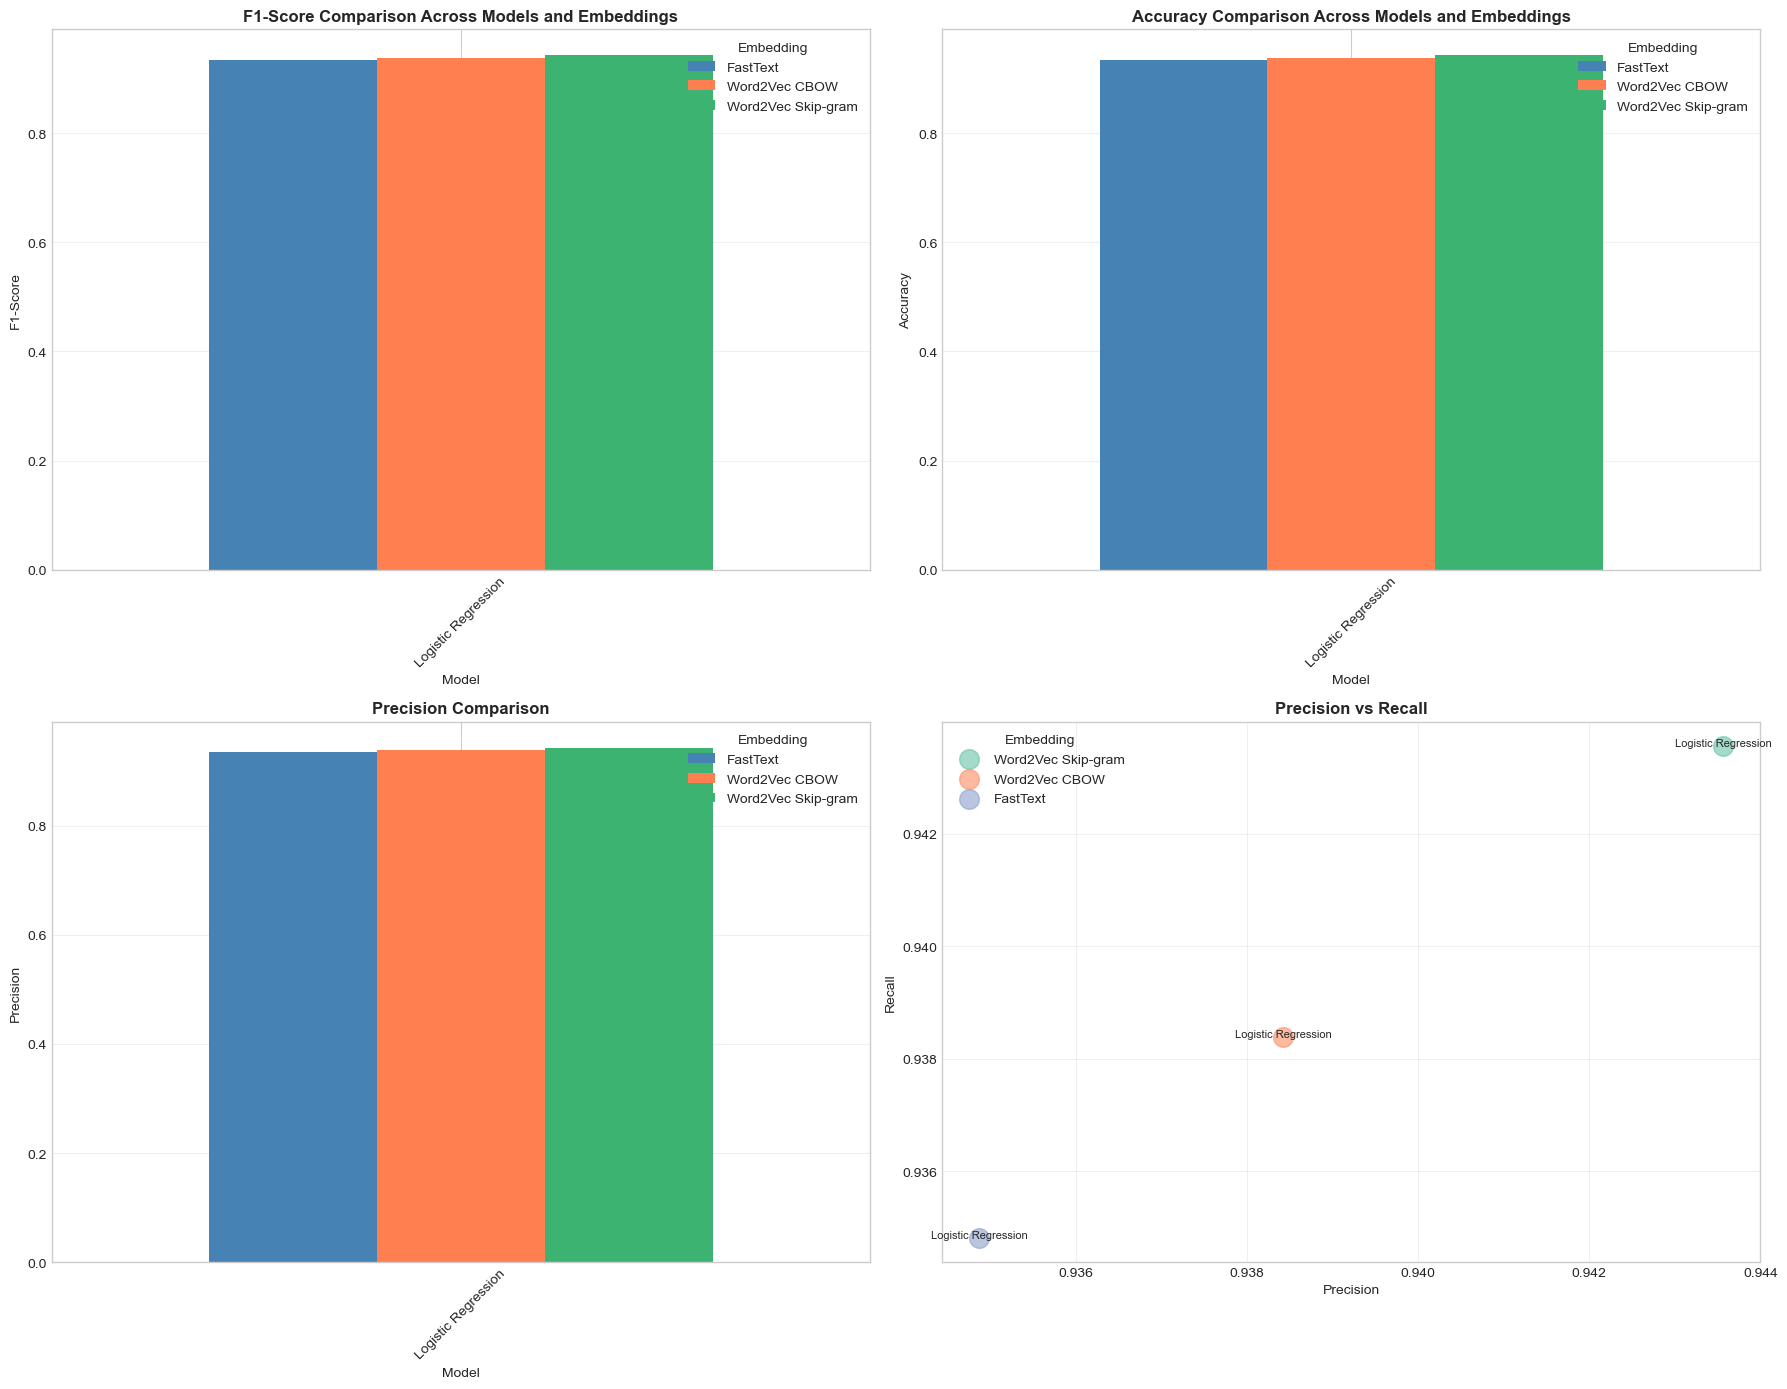

In [70]:
# Grouped bar chart comparing performance
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# F1-Score comparison
pivot_f1 = results_df.pivot(index='model', columns='embedding', values='f1_score')
pivot_f1.plot(kind='bar', ax=axes[0, 0], width=0.8, color=['steelblue', 'coral', 'mediumseagreen'])
axes[0, 0].set_title('F1-Score Comparison Across Models and Embeddings', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylabel('F1-Score')
axes[0, 0].legend(title='Embedding')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Accuracy comparison
pivot_acc = results_df.pivot(index='model', columns='embedding', values='accuracy')
pivot_acc.plot(kind='bar', ax=axes[0, 1], width=0.8, color=['steelblue', 'coral', 'mediumseagreen'])
axes[0, 1].set_title('Accuracy Comparison Across Models and Embeddings', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(title='Embedding')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Precision comparison
pivot_prec = results_df.pivot(index='model', columns='embedding', values='precision')
pivot_prec.plot(kind='bar', ax=axes[1, 0], width=0.8, color=['steelblue', 'coral', 'mediumseagreen'])
axes[1, 0].set_title('Precision Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Model')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(title='Embedding')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# Precision-Recall comparison
for embedding in results_df['embedding'].unique():
    emb_data = results_df[results_df['embedding'] == embedding]
    axes[1, 1].scatter(emb_data['precision'], emb_data['recall'], 
                      s=200, alpha=0.6, label=embedding)
    for idx, row in emb_data.iterrows():
        axes[1, 1].annotate(row['model'], 
                           (row['precision'], row['recall']),
                           fontsize=8, ha='center')

axes[1, 1].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend(title='Embedding')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../results/logistic_regression/performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

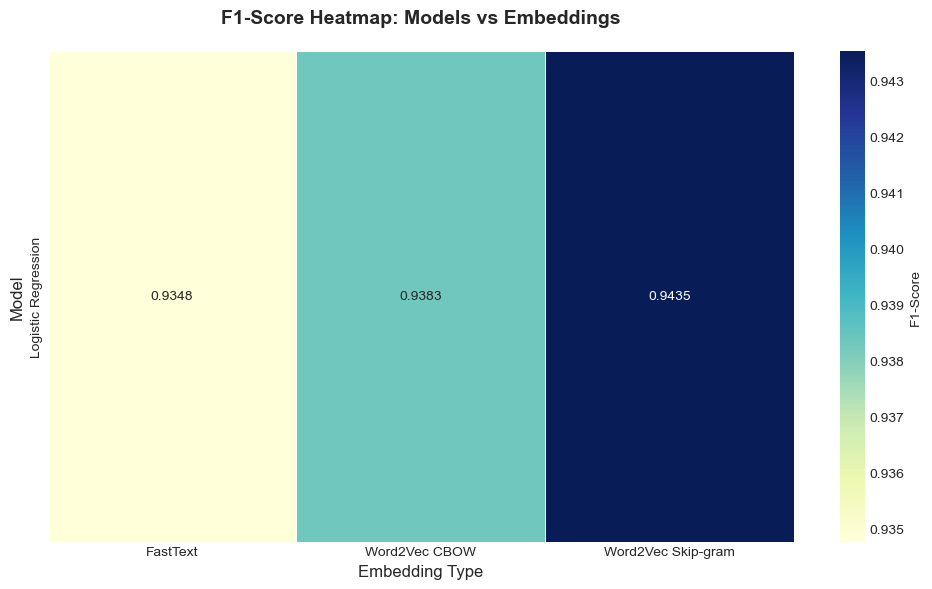

In [71]:
# Heatmap of F1-scores
fig, ax = plt.subplots(figsize=(10, 6))

pivot_f1 = results_df.pivot(index='model', columns='embedding', values='f1_score')
sns.heatmap(pivot_f1, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'F1-Score'}, ax=ax, linewidths=0.5)
ax.set_title('F1-Score Heatmap: Models vs Embeddings', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Embedding Type', fontsize=12)
ax.set_ylabel('Model', fontsize=12)

plt.tight_layout()
plt.savefig('../../results/logistic_regression/f1_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrices for Best Models

### Learning and Validation Curves

Learning curves show how model performance improves with more training data, while validation curves show how performance changes with different hyperparameter values.

Computing learning curve for Word2Vec Skip-gram...
Computing learning curve for Word2Vec CBOW...
Computing learning curve for FastText...


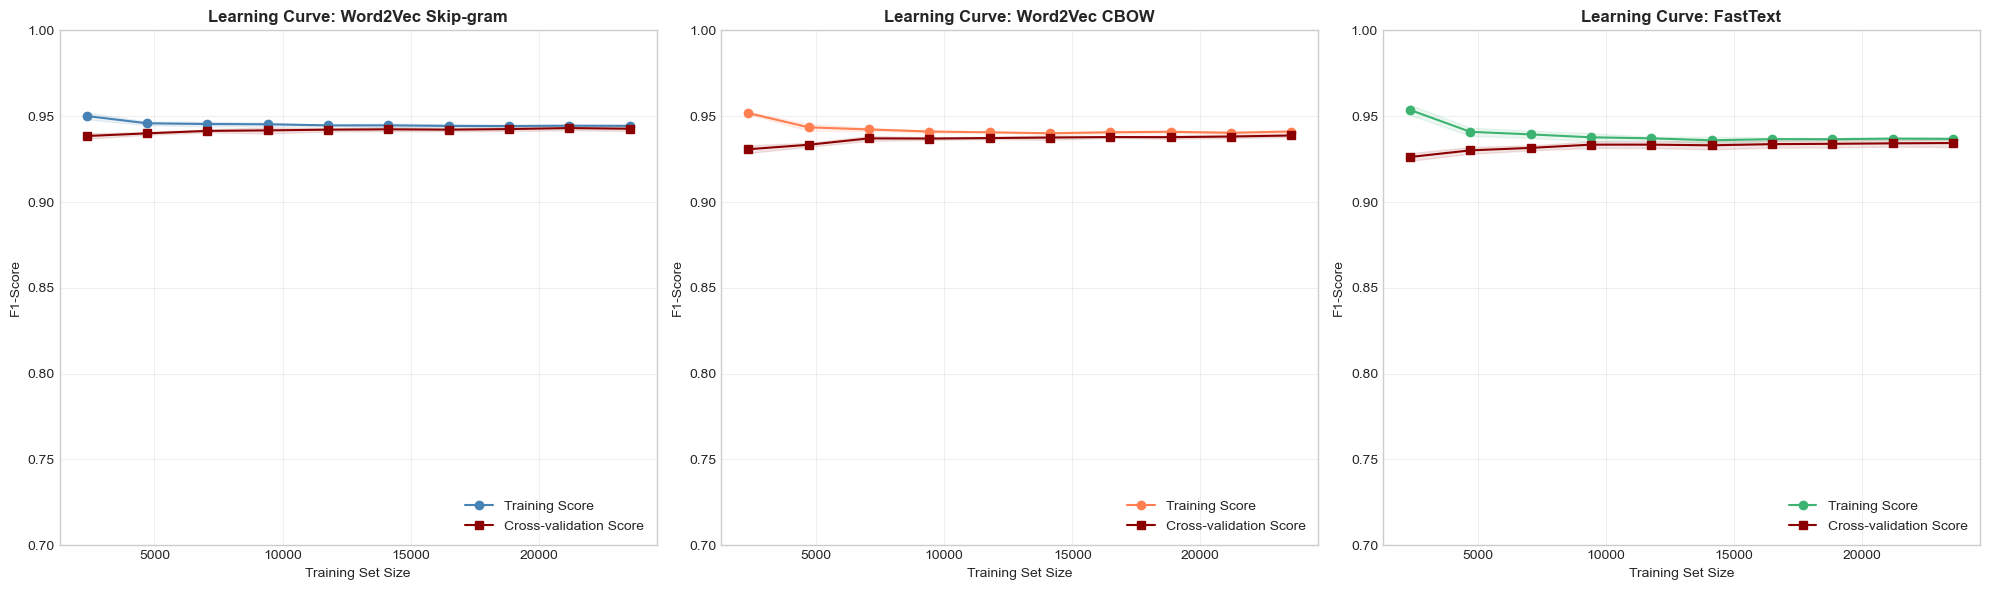

Learning curves completed!


In [72]:
# Learning curves for all embeddings
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

embeddings_data = [
    (X_train_skipgram, 'Word2Vec Skip-gram', 'steelblue'),
    (X_train_cbow, 'Word2Vec CBOW', 'coral'),
    (X_train_fasttext, 'FastText', 'mediumseagreen')
]

for idx, (X_data, emb_name, color) in enumerate(embeddings_data):
    print(f"Computing learning curve for {emb_name}...")
    
    # Create a simple logistic regression model
    model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', 
                               max_iter=500, random_state=RANDOM_STATE, 
                               class_weight='balanced')
    
    # Compute learning curve
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_data, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        random_state=RANDOM_STATE
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    ax = axes[idx]
    ax.plot(train_sizes, train_mean, 'o-', color=color, label='Training Score')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color=color)
    
    ax.plot(train_sizes, val_mean, 's-', color='darkred', label='Cross-validation Score')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='darkred')
    
    ax.set_title(f'Learning Curve: {emb_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Training Set Size', fontsize=10)
    ax.set_ylabel('F1-Score', fontsize=10)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig('../../results/logistic_regression/learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Learning curves completed!")

Computing validation curve for Word2Vec Skip-gram...
Computing validation curve for Word2Vec CBOW...
Computing validation curve for FastText...


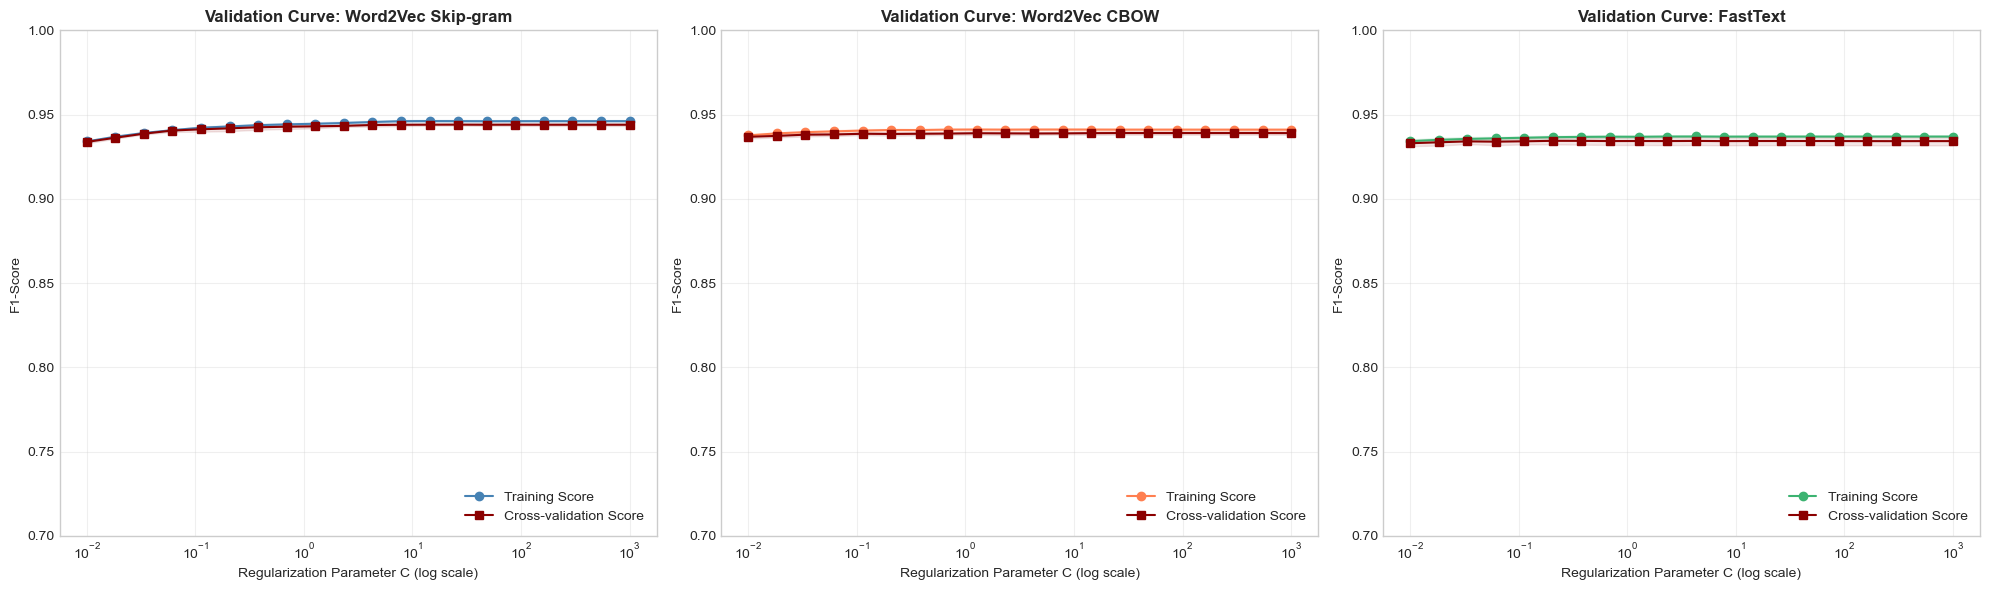

Validation curves completed!


In [73]:
# Validation curves for hyperparameter C (regularization strength)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

C_range = np.logspace(-2, 3, 20)  # From 0.01 to 1000

for idx, (X_data, emb_name, color) in enumerate(embeddings_data):
    print(f"Computing validation curve for {emb_name}...")
    
    # Create a simple logistic regression model
    model = LogisticRegression(penalty='l2', solver='liblinear', 
                               max_iter=500, random_state=RANDOM_STATE, 
                               class_weight='balanced')
    
    # Compute validation curve
    train_scores, val_scores = validation_curve(
        model, X_data, y_train,
        param_name='C',
        param_range=C_range,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    # Calculate mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)
    
    # Plot
    ax = axes[idx]
    ax.semilogx(C_range, train_mean, 'o-', color=color, label='Training Score')
    ax.fill_between(C_range, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color=color)
    
    ax.semilogx(C_range, val_mean, 's-', color='darkred', label='Cross-validation Score')
    ax.fill_between(C_range, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='darkred')
    
    ax.set_title(f'Validation Curve: {emb_name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Regularization Parameter C (log scale)', fontsize=10)
    ax.set_ylabel('F1-Score', fontsize=10)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig('../../results/logistic_regression/validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("Validation curves completed!")

Computing cross-validation metrics for Word2Vec Skip-gram...
Computing cross-validation metrics for Word2Vec CBOW...
Computing cross-validation metrics for FastText...


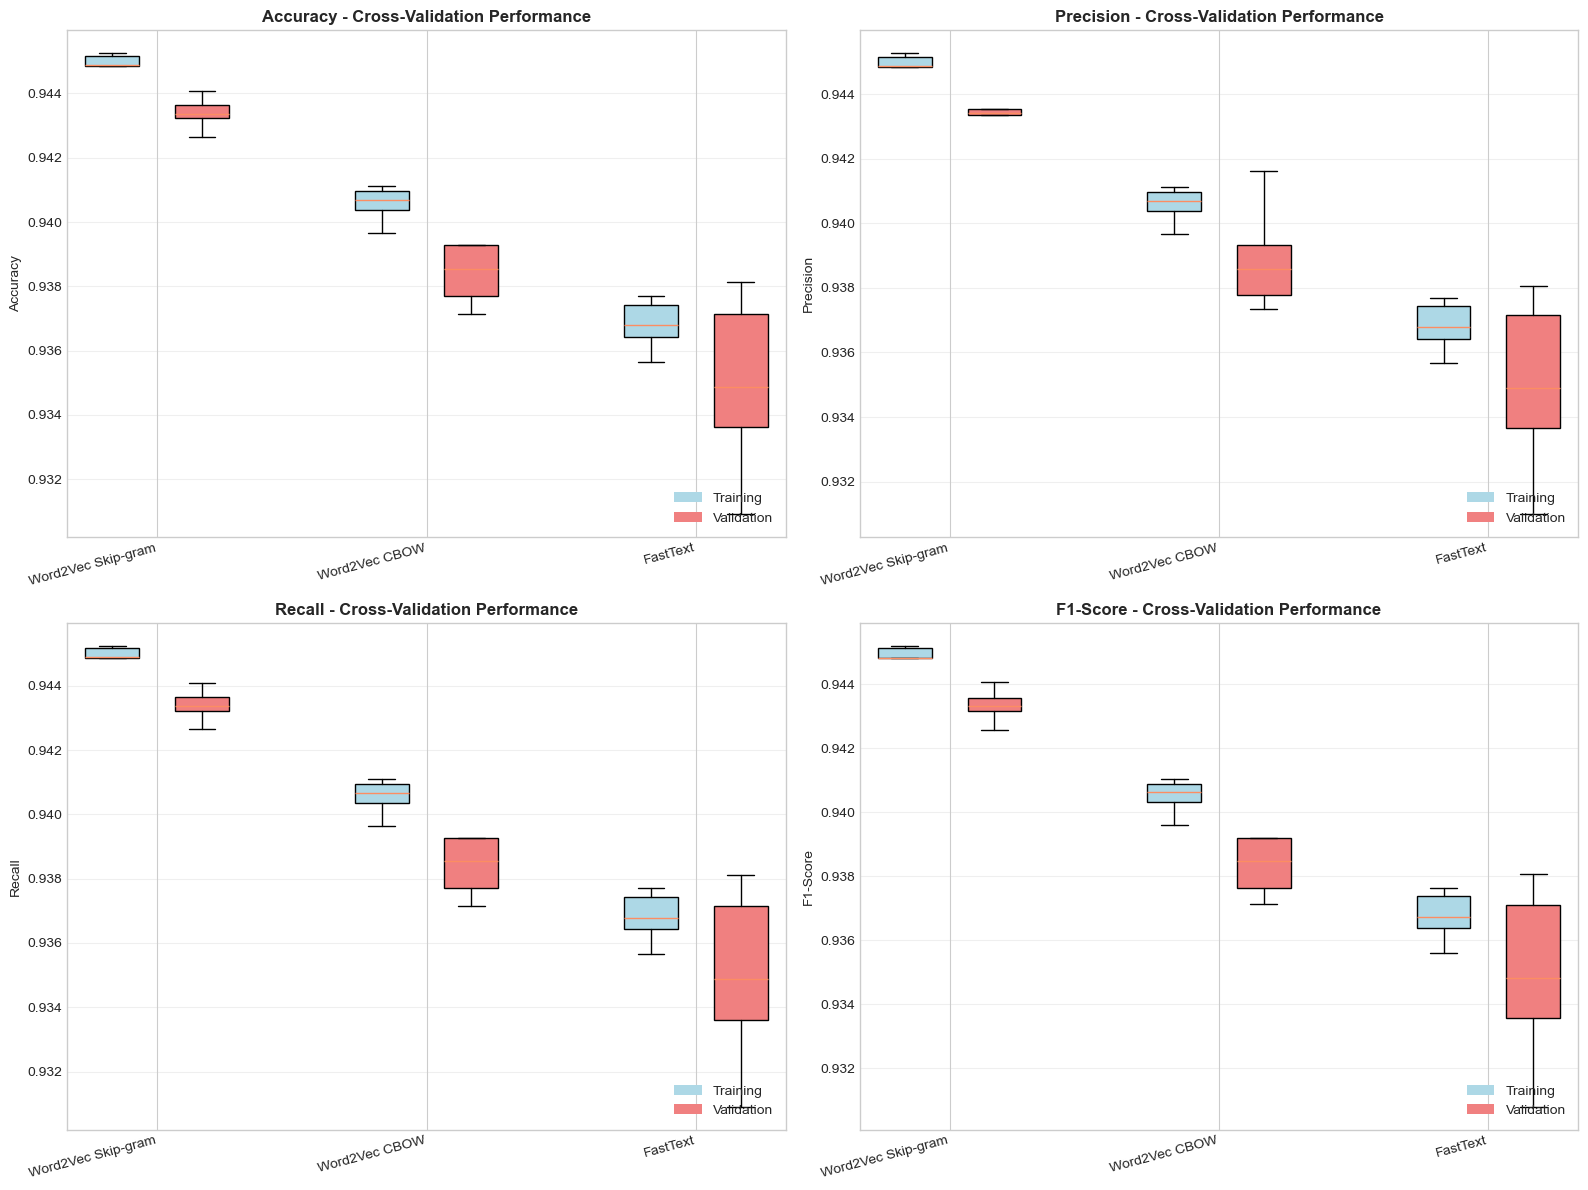

Cross-validation metrics visualization completed!


In [74]:
# Cross-validation metrics across folds
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

cv_results = {}

for X_data, emb_name, color in embeddings_data:
    print(f"Computing cross-validation metrics for {emb_name}...")
    
    model = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', 
                               max_iter=500, random_state=RANDOM_STATE, 
                               class_weight='balanced')
    
    # Perform cross-validation with multiple metrics
    scores = cross_validate(
        model, X_data, y_train,
        cv=5,
        scoring=metrics,
        n_jobs=-1,
        return_train_score=True
    )
    
    cv_results[emb_name] = scores

# Plot each metric
for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    positions = []
    train_data = []
    val_data = []
    labels = []
    
    for pos, (emb_name, color) in enumerate([(en, ec) for _, en, ec in embeddings_data]):
        scores = cv_results[emb_name]
        train_scores = scores[f'train_{metric}']
        val_scores = scores[f'test_{metric}']
        
        # Box plot data
        bp_train = ax.boxplot([train_scores], positions=[pos*3], widths=0.6,
                               patch_artist=True, showfliers=False)
        bp_val = ax.boxplot([val_scores], positions=[pos*3 + 1], widths=0.6,
                            patch_artist=True, showfliers=False)
        
        # Color the boxes
        for patch in bp_train['boxes']:
            patch.set_facecolor('lightblue')
        for patch in bp_val['boxes']:
            patch.set_facecolor('lightcoral')
        
        labels.append(emb_name)
    
    # Set labels and title
    ax.set_title(f'{metric_name} - Cross-Validation Performance', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_name, fontsize=10)
    ax.set_xticks([i*3 + 0.5 for i in range(len(embeddings_data))])
    ax.set_xticklabels([en for _, en, _ in embeddings_data], rotation=15, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add legend
    legend_elements = [Patch(facecolor='lightblue', label='Training'),
                      Patch(facecolor='lightcoral', label='Validation')]
    ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../../results/logistic_regression/cv_metrics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Cross-validation metrics visualization completed!")

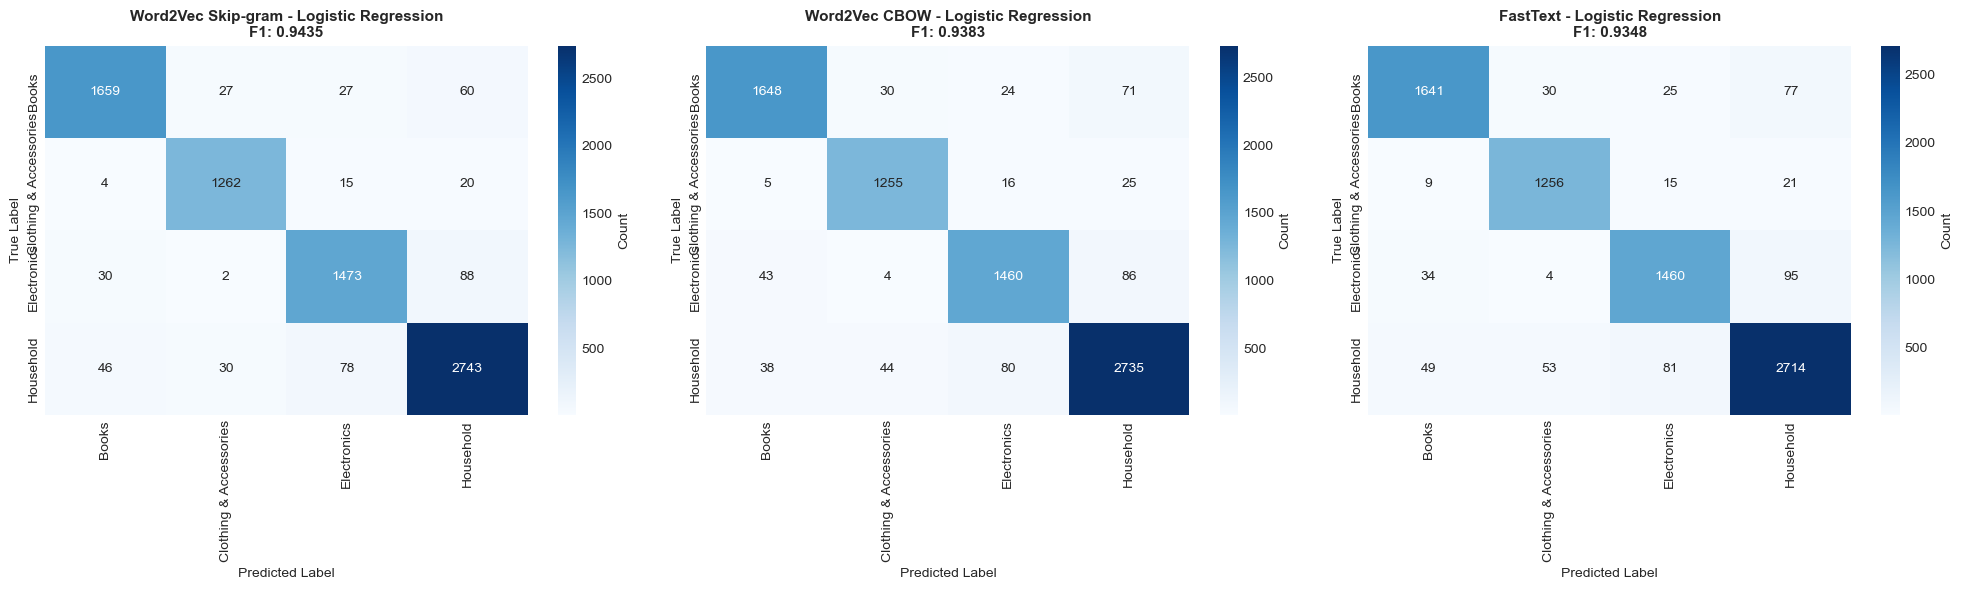

In [75]:
# Plot confusion matrices for the best model from each embedding
def plot_confusion_matrix(y_true, y_pred, title, ax):
    """Plot confusion matrix on given axis"""
    cm = confusion_matrix(y_true, y_pred)
    labels = np.unique(y_true)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=labels, yticklabels=labels,
                cbar_kws={'label': 'Count'})
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Find best model for each embedding
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, embedding in enumerate(results_df['embedding'].unique()):
    emb_results = results_df[results_df['embedding'] == embedding]
    best_idx = emb_results['f1_score'].idxmax()
    best_model_name = emb_results.loc[best_idx, 'model']
    
    # Get predictions
    model_key = f"{best_model_name}_{embedding}"
    y_pred = trained_models[model_key]['predictions']
    
    title = f"{embedding} - {best_model_name}\nF1: {emb_results.loc[best_idx, 'f1_score']:.4f}"
    plot_confusion_matrix(y_test, y_pred, title, axes[idx])

plt.tight_layout()
plt.savefig('../../results/logistic_regression/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

### Detailed Classification Reports

In [76]:
# Print detailed classification report for best overall model
best_overall_idx = results_df['f1_score'].idxmax()
best_embedding = results_df.loc[best_overall_idx, 'embedding']
best_model = results_df.loc[best_overall_idx, 'model']
best_f1 = results_df.loc[best_overall_idx, 'f1_score']

print("\n" + "="*80)
print("BEST OVERALL MODEL")
print("="*80)
print(f"Model: {best_model}")
print(f"Embedding: {best_embedding}")
print(f"F1-Score: {best_f1:.4f}")
print("\nDetailed Classification Report:")
print("="*80 + "\n")

model_key = f"{best_model}_{best_embedding}"
y_pred_best = trained_models[model_key]['predictions']
print(classification_report(y_test, y_pred_best, digits=4))


BEST OVERALL MODEL
Model: Logistic Regression
Embedding: Word2Vec Skip-gram
F1-Score: 0.9435

Detailed Classification Report:

                        precision    recall  f1-score   support

                 Books     0.9540    0.9357    0.9448      1773
Clothing & Accessories     0.9553    0.9700    0.9626      1301
           Electronics     0.9247    0.9247    0.9247      1593
             Household     0.9423    0.9468    0.9446      2897

              accuracy                         0.9435      7564
             macro avg     0.9441    0.9443    0.9442      7564
          weighted avg     0.9436    0.9435    0.9435      7564



In [77]:
# Classification reports for each embedding's best model
for embedding in results_df['embedding'].unique():
    emb_results = results_df[results_df['embedding'] == embedding]
    best_idx = emb_results['f1_score'].idxmax()
    best_model_name = emb_results.loc[best_idx, 'model']
    best_f1 = emb_results.loc[best_idx, 'f1_score']
    
    print("\n" + "="*80)
    print(f"BEST MODEL FOR {embedding}")
    print("="*80)
    print(f"Model: {best_model_name}")
    print(f"F1-Score: {best_f1:.4f}")
    print("\nDetailed Classification Report:")
    print("-"*80 + "\n")
    
    model_key = f"{best_model_name}_{embedding}"
    y_pred = trained_models[model_key]['predictions']
    print(classification_report(y_test, y_pred, digits=4))


BEST MODEL FOR Word2Vec Skip-gram
Model: Logistic Regression
F1-Score: 0.9435

Detailed Classification Report:
--------------------------------------------------------------------------------

                        precision    recall  f1-score   support

                 Books     0.9540    0.9357    0.9448      1773
Clothing & Accessories     0.9553    0.9700    0.9626      1301
           Electronics     0.9247    0.9247    0.9247      1593
             Household     0.9423    0.9468    0.9446      2897

              accuracy                         0.9435      7564
             macro avg     0.9441    0.9443    0.9442      7564
          weighted avg     0.9436    0.9435    0.9435      7564


BEST MODEL FOR Word2Vec CBOW
Model: Logistic Regression
F1-Score: 0.9383

Detailed Classification Report:
--------------------------------------------------------------------------------

                        precision    recall  f1-score   support

                 Books     0.9504    

## Summary

This notebook implemented a comprehensive comparative analysis of Logistic Regression for text classification using multiple Word2Vec-based embedding techniques:

**Embeddings Evaluated**:
- Word2Vec Skip-gram (context prediction from target)
- Word2Vec CBOW (target prediction from context)
- FastText (subword n-gram representations)

